In [ ]:
%pip install PyWavelets
import pywt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
import pickle
import plotly.express as px
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
import neurokit2 as nk
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 6)
import os, re
from importlib import reload
import empatica_helpers as eh
import helpers as h
import heartpy as hp

# eh.move_folders_to_root('input/empatica/')
# eh.rename_folders('input/empatica/')

dir_list = h.get_dir_list('input/empatica/')

df = pd.read_csv('output/empatica_raw.csv')
ibi_df = pd.read_csv('output/empatica_ibi.csv')
df.head()
len(df)

Note: you may need to restart the kernel to use updated packages.


/var/folders/4y/grqbq6j10592pmzzhgzbxdmr0000gn/T/ipykernel_6277/3126355324.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


12413182

## PPG Filtering

Src: [Goda, M. A., Charlton, P. H., & Behar, J. A. (2023). pyPPG: A Python toolbox for comprehensive photoplethysmography signal analysis. DOI 10.1088/1361-6579/ad33a2](https://iopscience.iop.org/article/10.1088/1361-6579/ad33a2)

- **Bandpass filtering between 0.5-12 Hz**: A fourth-order Chebyshev Type II filter was used for the original signal. The 12 Hz low-pass cut-off was used to avoid time-shifting of fiducial points (particularly pulse onset, and dicrotic notch) and to eliminate unwanted high-frequency content from the PPG derivatives. The 0.5 Hz high-pass cut-off was used to minimize baseline wandering whilst retaining content at low heart rates.
- **50 ms moving average filtering (MAF)**: In the case of very noisy signals, some high-frequency content can remain in the band-pass filter signal. For this purpose, a 50 ms standard flat (boxcar or top-hat) MAF with a 9 Hz cut-off frequency was applied after the band-pass filtering.

In [ ]:
sampling_rate = 64
ppg = df['bvp']
ppg_clean = nk.ppg_clean(ppg, sampling_rate) # Elgendi, M., Norton, I., Brearley, M., Abbott, D., & Schuurmans, D. (2013). Systolic peak detection in acceleration photoplethysmograms measured from emergency responders in tropical conditions. PloS one, 8(10), e76585.

ppg_df = pd.DataFrame({'ppg': ppg, 'ppg_clean': ppg_clean})
ppg_df = ppg_df.reset_index()

**AlthoughpyPPG notes a 12 Hz cutoff frequency, another study notes 6 as a good cutoff frequency (1. Pollreisz D, TaheriNejad N. Detection and Removal of Motion Artifacts in PPG Signals. Mobile Netw Appl. 2022 Apr 1;27(2):728–38. **

In [ ]:
import numpy as np
import pandas as pd
from scipy import signal
import neurokit2 as nk

smoothing_window = 100 # in ms

# Bandpass filter
b, a = signal.cheby2(N=4, rs = 20, fs = 64, btype = 'bandpass', Wn = [0.5000001, 6]) # 0.5-12 Hz according to PyPPG, 0.5-6 Hz according to Pollreisz
ppg_bandpassed = signal.filtfilt(b, a, ppg_clean)
ppg_df['ppg_bandpassed'] = ppg_bandpassed

# Moving average
win = round(sampling_rate * smoothing_window/1000)
B = 1 / win * np.ones(win)
ppg_moving_average = signal.filtfilt(B, 1, ppg_bandpassed)
ppg_df['ppg_moving_average'] = ppg_moving_average

# Variable moving average
# # Calculate standard deviation of the signal over a certain window
# window_size = 250 # in ms
# win = round(sampling_rate * window_size/1000)
# var = ppg_df['ppg_bandpassed'].rolling(window=win, center=True).var()

# # Scale standard deviation values to the range [50, 500]
# min_win = 50
# max_win = 500
# var_scaled = ((var - var.min()) / (var.max() - var.min())).fillna(0)
# var_scaled = var_scaled.fillna(0)

# assert len(var_scaled) == len(ppg_df['ppg_bandpassed']), "Length of std_dev_scaled does not match length of ppg_bandpassed."

# # Variable moving average
# # win_list = []
# # for i in range(len(ppg_df['ppg_bandpassed'])):
# #     win = int(var_scaled[i] * max_win)
# #     if win < min_win:
# #         win = min_win
# #     win_list.append(win)
# # B = [1 / win * np.ones(win) for win in win_list]


a FIR hamming window low-pass filter with 20 dB attenuation at 8 Hz to wipe out most of the high frequency noise. ([Peng, 2014/12](zotero://select/items/2_H8SKC8XR))


In [ ]:
ppg_fir_filtered = nk.signal_filter(ppg, sampling_rate=64, highcut=12)
ppg_df['ppg_fir_filtered'] = ppg_fir_filtered

ppg_dc_removed = nk.signal_filter(ppg, sampling_rate=64, method='powerline')
ppg_df['ppg_dc_removed'] = ppg_dc_removed

temp = nk.signal_filter(ppg_moving_average, sampling_rate=64, highcut=12)
ppg_all_filters_applied = nk.signal_filter(temp, sampling_rate=64, method="powerline")

ppg_df['ppg_all_filters_applied'] = ppg_all_filters_applied

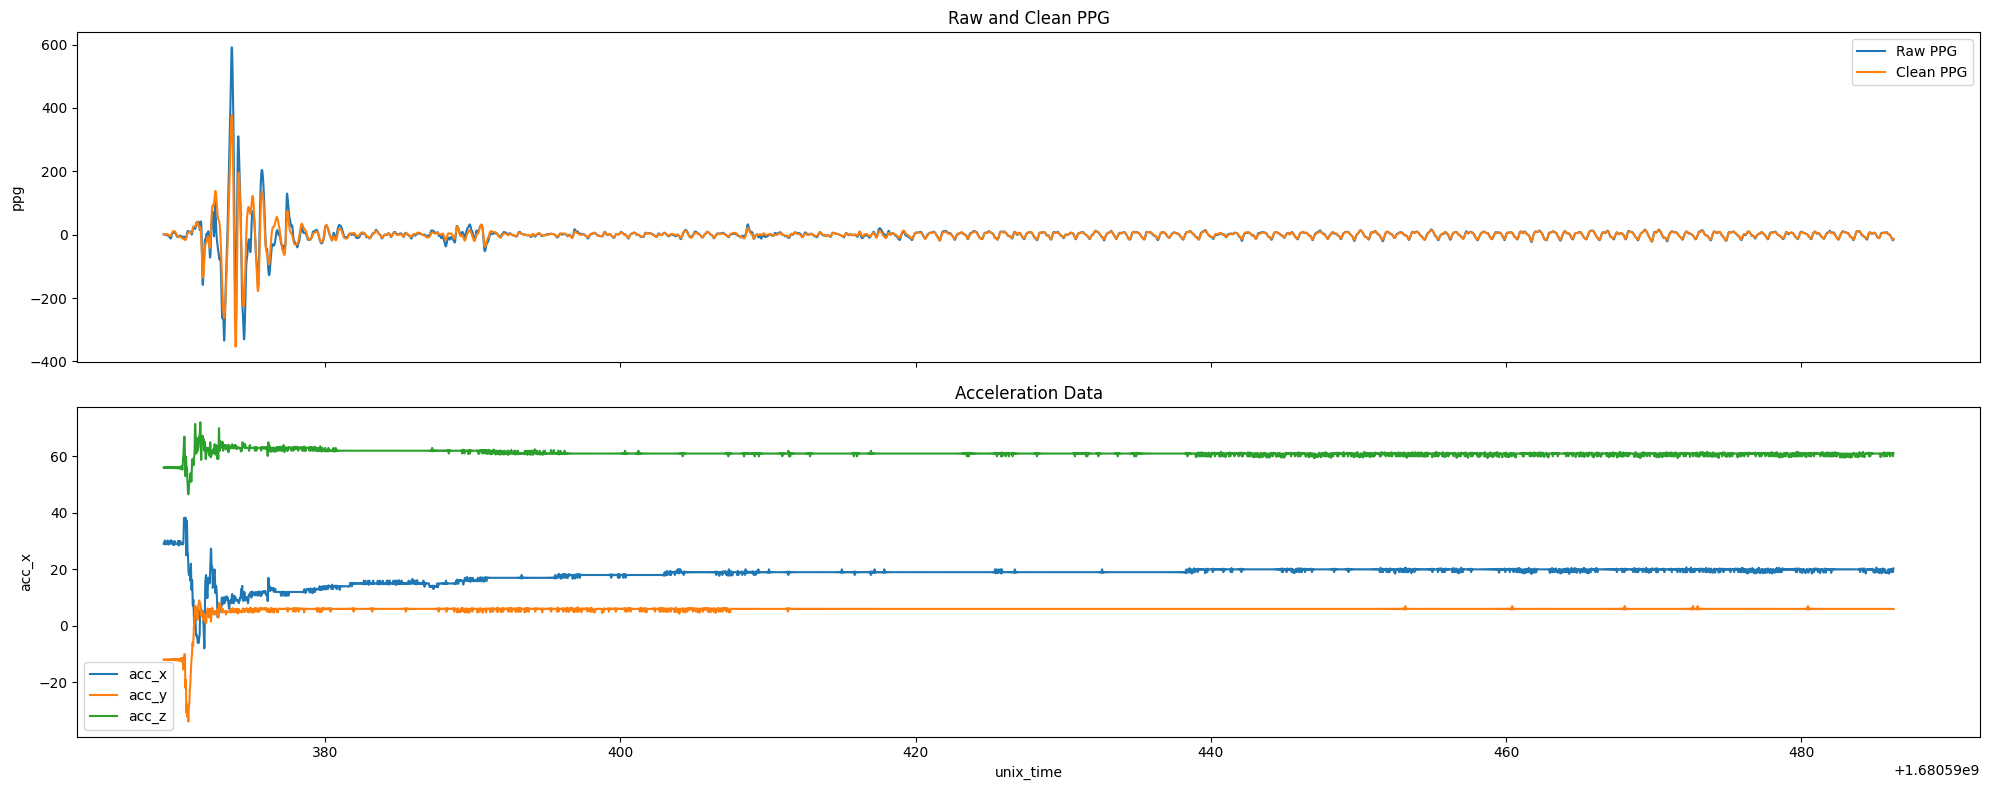

In [ ]:
fig, axs = plt.subplots(2, sharex=True, figsize=(20, 8))

start = 2500
stop = 10000
# Plot timeseries of both raw and clean PPG using sns
sns.lineplot(data=ppg_df[start:stop], x=df['unix_time'][start:stop], y='ppg', ax=axs[0], label='Raw PPG')
sns.lineplot(data=ppg_df[start:stop], x=df['unix_time'][start:stop], y='ppg_all_filters_applied', ax=axs[0], label='Clean PPG')
axs[0].legend()
axs[0].set_title('Raw and Clean PPG')

# Add a plot that shares the same x-axis, showing df['acc_x'], df['acc_y'], and df['acc_z'] using sns
sns.lineplot(data=df[start:stop], x='unix_time', y='acc_x', ax=axs[1], label='acc_x')
sns.lineplot(data=df[start:stop], x='unix_time', y='acc_y', ax=axs[1], label='acc_y')
sns.lineplot(data=df[start:stop], x='unix_time', y='acc_z', ax=axs[1], label='acc_z')
axs[1].legend()
axs[1].set_title('Acceleration Data')

plt.tight_layout()
plt.show()

Let's see how our peak detection does on a clean part of the signal. 

In [ ]:
print(len(ppg_df))
print(ppg_df.index)

12413182
RangeIndex(start=0, stop=12413182, step=1)


Peak detection works fine on parts without motion artefacts!

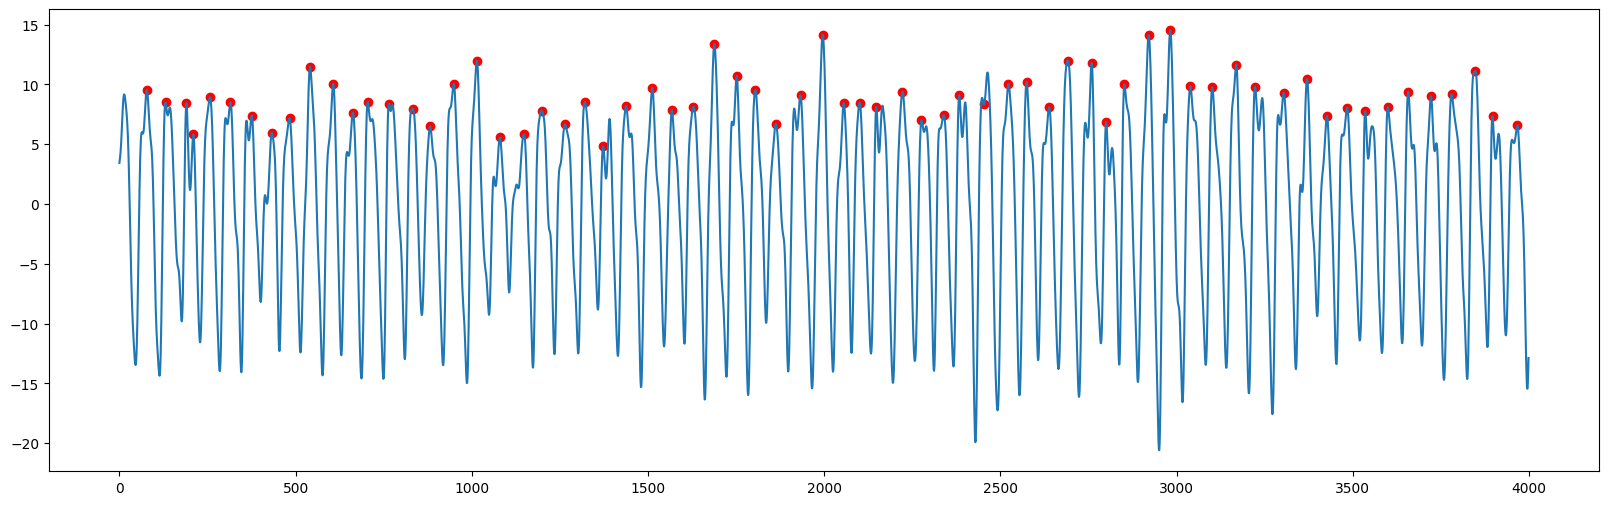

In [ ]:
# ppg_all_filters_applied
info_all_filters_applied = nk.ppg_findpeaks(ppg_df['ppg_all_filters_applied'][6000:10000], sampling_rate)
ppg_peaks_all_filters_applied = info_all_filters_applied['PPG_Peaks']
artifacts_all_filters_applied_corrected, ppg_peaks_all_filters_applied_corrected = nk.signal_fixpeaks(ppg_peaks_all_filters_applied, sampling_rate, iterative=True, method="Kubios") # Lipponen, J. A., & Tarvainen, M. P. (2019)

# Plot the signal and the peaks
plt.plot(ppg_df['ppg_all_filters_applied'][6000:10000].values)
plt.scatter(ppg_peaks_all_filters_applied_corrected, ppg_df['ppg_all_filters_applied'][6000:10000].iloc[ppg_peaks_all_filters_applied_corrected].values, color='r')
plt.show()

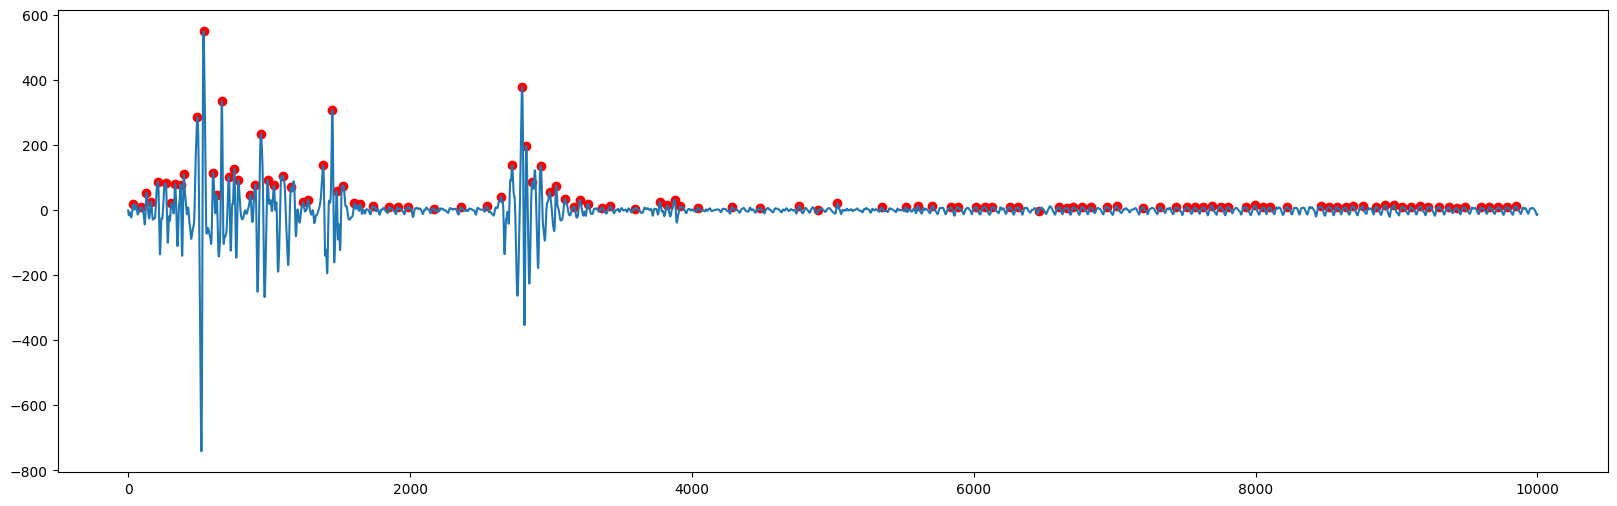

In [ ]:
# Define start and stop variables
start = 0
stop = 10000

# ppg_all_filters_applied
info_all_filters_applied = nk.ppg_findpeaks(ppg_df['ppg_all_filters_applied'][start:stop], sampling_rate)
ppg_peaks_all_filters_applied = info_all_filters_applied['PPG_Peaks']
artifacts_all_filters_applied_corrected, ppg_peaks_all_filters_applied_corrected = nk.signal_fixpeaks(ppg_peaks_all_filters_applied, sampling_rate, iterative=True, method="Kubios") # Lipponen, J. A., & Tarvainen, M. P. (2019)

# Plot the signal and the peaks
plt.plot(ppg_df['ppg_all_filters_applied'][start:stop].values)
plt.scatter(ppg_peaks_all_filters_applied_corrected, ppg_df['ppg_all_filters_applied'][start:stop].iloc[ppg_peaks_all_filters_applied_corrected].values, color='r')
plt.show()

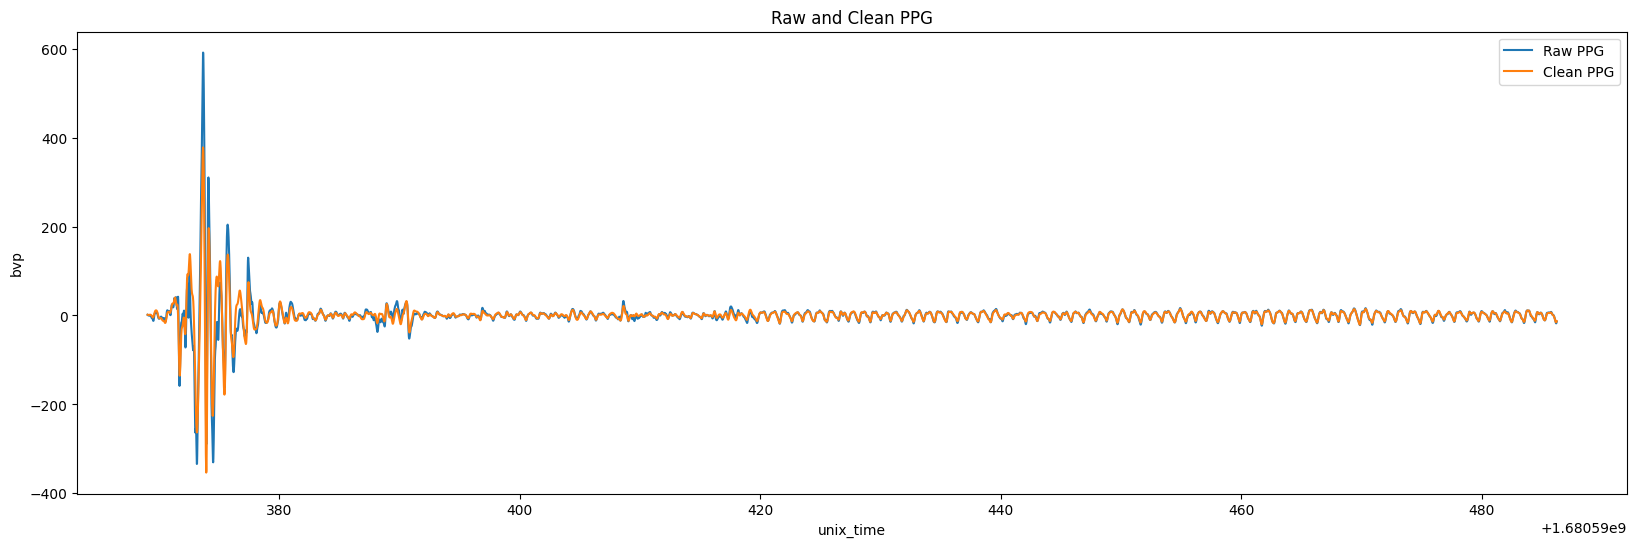

In [ ]:
df['ppg_all_filters_applied'] = ppg_all_filters_applied

start = 2500
stop = 10000

# Define the figure and axes for the subplots
fig, axs = plt.subplots()

# Plot timeseries of both raw and clean PPG using sns
sns.lineplot(data=df[start:stop], x=df['unix_time'][start:stop], y='bvp', ax=axs, label='Raw PPG')
sns.lineplot(data=df[start:stop], x=df['unix_time'][start:stop], y='ppg_all_filters_applied', ax=axs, label='Clean PPG')
axs.legend()
axs.set_title('Raw and Clean PPG')

plt.show()

## Correcting motion artefacts

### ICA

In [ ]:
import os
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs


df2 = df[['acc_x', 'acc_y', 'acc_z', 'ppg_all_filters_applied', 'eda', 'temp', 'unix_time']]
# Rename ppg_all_filters_applied to ppg
# df2 = df2.rename(columns={'ppg_all_filters_applied': 'ppg'})
df2 = df2.set_index('unix_time')
df2 = df2.rename_axis('time')

df2 = df2.T # Transpose

# Create MNE Info
ch_types = ['bio'] * 5 + ['misc']
info = mne.create_info(ch_names=df2.index.tolist(), sfreq=64, ch_types=ch_types)

# Create MNE RawArray
raw = mne.io.RawArray(df2, info)

KeyError: "['ppg_all_filters_applied'] not in index"

In [ ]:
# Implement ICA using MNE
# raw.crop(tmax=120)
# raw.load_data()

# ica = ICA(n_components=15, max_iter="auto", random_state=97)
# ica.fit(raw, verbose = True, picks='eeg')

**MNE APPEARS TO NOT WORK**

## Wavelet decode for PPG

In [ ]:
df.columns

Index(['acc_x', 'acc_y', 'acc_z', 'temp', 'eda', 'bvp', 'hr', 'datetime',
       'unix_time', 'source', 'ppg_all_filters_applied'],
      dtype='object')

### IT WORKS

"For example, when fs is 25 Hz instead of 125 Hz, the number of frequency bins, N , should take about 1/5 of the original value such that other parameters’ values (e.g. ∆s and ∆) maintain the same physical measures." 

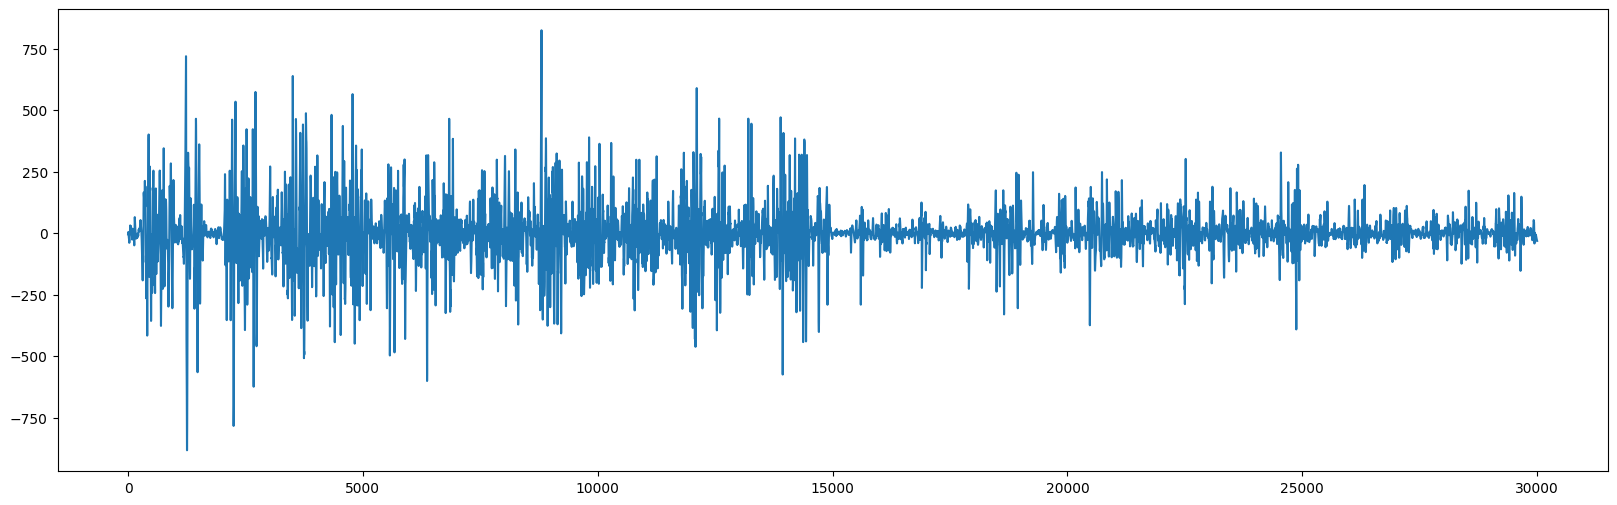

In [ ]:
# https://github.com/maryambayat-code/WAVELET-PPG/blob/main/waveletcodeforPPG.ipynb
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import scipy.signal as signal
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from scipy.signal import savgol_filter

ppg = df['bvp'].to_numpy()

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a
def butter_highpass_filter(data,cutoff,fs,order=5):
    b,a=butter_highpass(cutoff,fs,order=order)
    y=signal.filtfilt(b,a,data)
    return y

filterd2 = butter_highpass_filter(ppg, cutoff=0.5, fs=64)

sns.lineplot(data=filterd2[15000:45000])
plt.show()

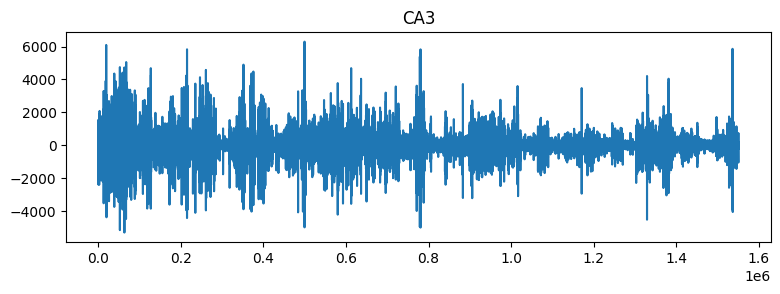

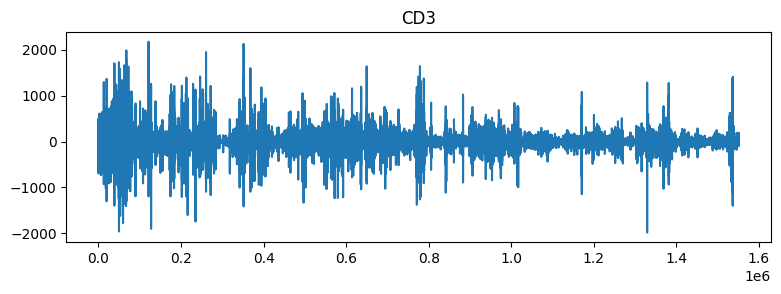

1551650
1551650


In [ ]:
# CHECK MODES: https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes

# coeff = pywt.wavedec(filterd2, wavelet='db2', level=3)
coeff = pywt.wavedec(filterd2, wavelet='db2', level=3)

# For example, when fs is 25 Hz instead of 125 Hz, the number of frequency bins, N , should take about 1/5 of the original value such that other parameters’ values (e.g. ∆s and ∆) maintain the same physical measures.
# Calculate the original number of frequency bins
original_num_bins = len(coeff)

# Calculate the new number of frequency bins
new_num_bins = int(original_num_bins * 0.5333)
# If frequency bins should become 1/5th when frequency goes from 125 to 25hz, what would the change need to be when frequency goes from 120 to 64 Hz? If the frequency is reduced from 120 Hz to 64 Hz, the ratio of the new frequency to the old frequency is 64/120 = 0.5333. So, if you want to maintain the same physical measures, you should also reduce the number of frequency bins to about 0.5333 (or 53.33%) of the original number.

coeff = coeff[:new_num_bins] # BUT NOW THE FINAL SIGNAL IS HALF THE ORIGINAL LENGTH

plt.subplot(221)
plt.plot(coeff[0])
plt.title('CA3')
plt.show()
plt.subplot(222)
plt.plot(coeff[1])
plt.title('CD3')
plt.show()
# Half the original components

print(len(coeff[0]))
print(len(coeff[1]))

In [ ]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

# coeff = pywt.wavedec(filterd2, wavelet='db2', level=3)
final_y=[]

# final_y.append(coeff[0])
# final_y.append(coeff[1])
####thresholdingOn0-4Coefficients
for k in range(0, 2):
    print("Shape of coeff[k]:", coeff[k].shape)
    temp = np.zeros(coeff[k].shape)
    print("Shape of temp:", temp.shape)
    sigma = (1/0.6745) * (np.mean(coeff[k]))
    alphathresh = sigma * np.sqrt(2 * np.log(len(coeff[k])))
    gamaathresh=0.8*alphathresh
    alpha=-(1/gamaathresh)*(np.log2((alphathresh-gamaathresh)/(alphathresh+gamaathresh)))
    print(gamaathresh)
    for i in range(0,len(coeff[k])):
        print(f'gama={gamaathresh},alpha={alpha}')
        if coeff[k][i]>=-gamaathresh and coeff[k][i]<=(gamaathresh) :
            print(f'x<thresh= {x[i]}')
            #final_y.append(coeff[1])
            temp[i] = coeff[k][i]
        else:
            coeff[k][i]=(1-np.exp(-alpha*coeff[k][i]))/(1+np.exp(-alpha*coeff[k][i]))*alphathresh
            #coeff[k][i]=0
            print(f'x>thresh= {x[i]}')
            #final_y.append(coeff[1])
            temp[i] = coeff[k][i]
            print(coeff[1].shape)
    final_y.append(temp)
plt.plot(filterd2)
plt.title('original signal')
plt.show()
####reconstructingsignalviathresholdedcoeffs
signal=pywt.waverec(final_y,wavelet='db2')
plt.plot(signal)
plt.title('reconstructed signal')
plt.show()
# print(pywt.wavelist(kind='discrete'))

from scipy.signal import savgol_filter
signal2=savgol_filter(signal,5,3)
plt.plot(signal2,color='red')
plt.title('reconstructed signal after savgol filter')
plt.show()

Shape of coeff[k]: (1551650,)
Shape of temp: (1551650,)
-0.0004934796634915725
gama=-0.0004934796634915725,alpha=-6423.61830883523


NameError: name 'x' is not defined

3103322
3103318


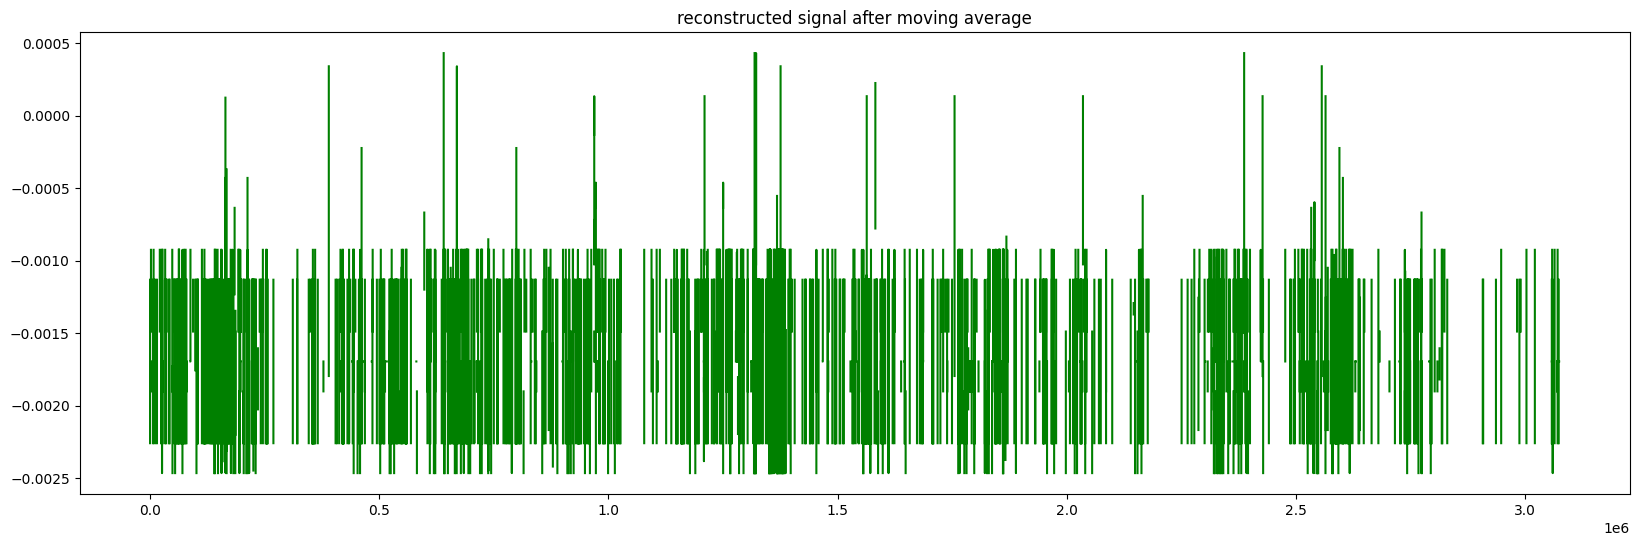

In [ ]:
window_size = 5
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
signal1=np.array(signal).astype(float)
print(len(signal))
# Loop through the array t o
# consider every window of size 3
while i < len(signal) - window_size + 1:
 
    # Calculate the average of current window
    window_average = np.sum(signal[i:i+window_size])/window_size
     
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
     
    # Shift window to right by one position
    i += 1
   
yd=moving_averages
xd =  np.arange(len(yd))
print(len(yd))
plt.plot(yd, color='g')
plt.title('reconstructed signal after moving average')

plt.show()


### Lets test its peak detectability

/Users/koenraijer/Documents/00_Werk_en_studie/Msc_Data_Science_&_Society/Thesis/Preprocessing/.conda/lib/python3.11/site-packages/neurokit2/ppg/ppg_clean.py:73: NeuroKitWarning: There are 3100556 missing data points in your signal. Filling missing values using `signal_fillmissing`.
  warn(


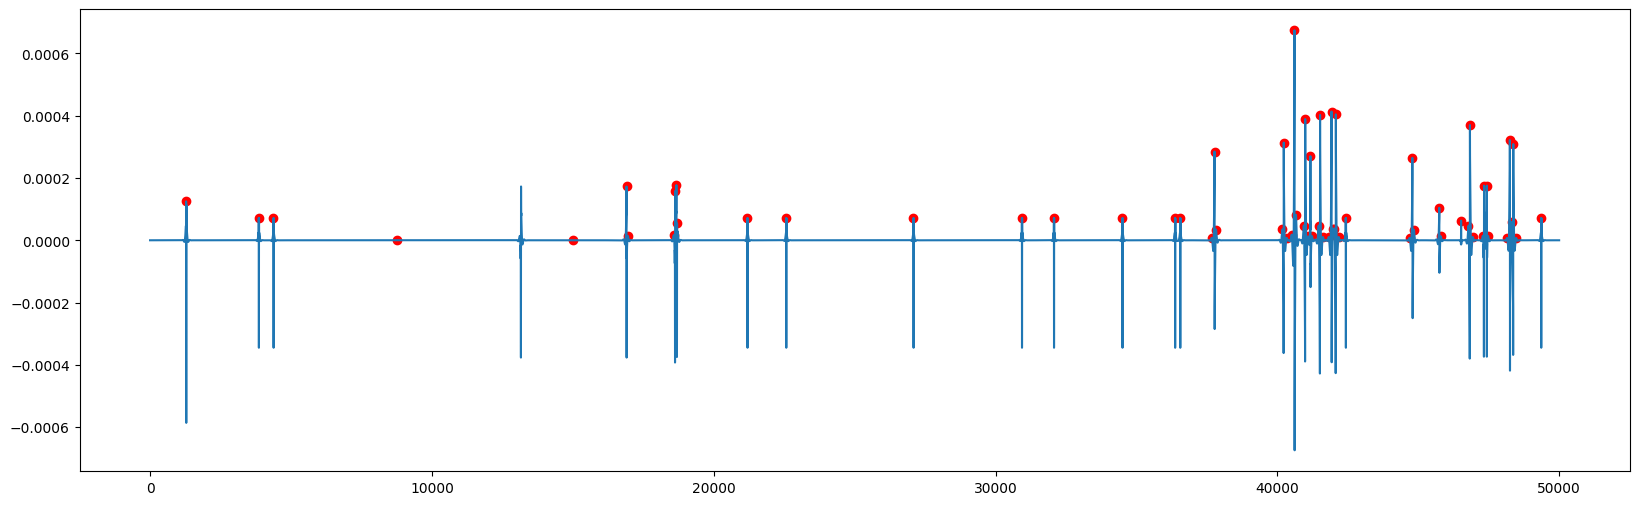

In [ ]:
# Define start and stop variables
start = 100000
stop = 150000

ppg_clean = nk.ppg_clean(signal, sampling_rate=50)
# ppg_all_filters_applied
info = nk.ppg_findpeaks(ppg_clean[start:stop], sampling_rate)
ppg_peaks = info['PPG_Peaks']
artifacts, ppg_peaks_corrected = nk.signal_fixpeaks(ppg_peaks, sampling_rate, iterative=True, method="Kubios") # Lipponen, J. A., & Tarvainen, M. P. (2019)

# Plot the signal and the peaks
plt.plot(ppg_clean[start:stop])
plt.scatter(ppg_peaks_corrected, ppg_clean[start:stop][ppg_peaks_corrected], color='r')
plt.show()

In [ ]:
print(len(filterd2))
print(len(signal))
signal

12413182
3103322


IndexError: index 40031 is out of bounds for axis 0 with size 40000

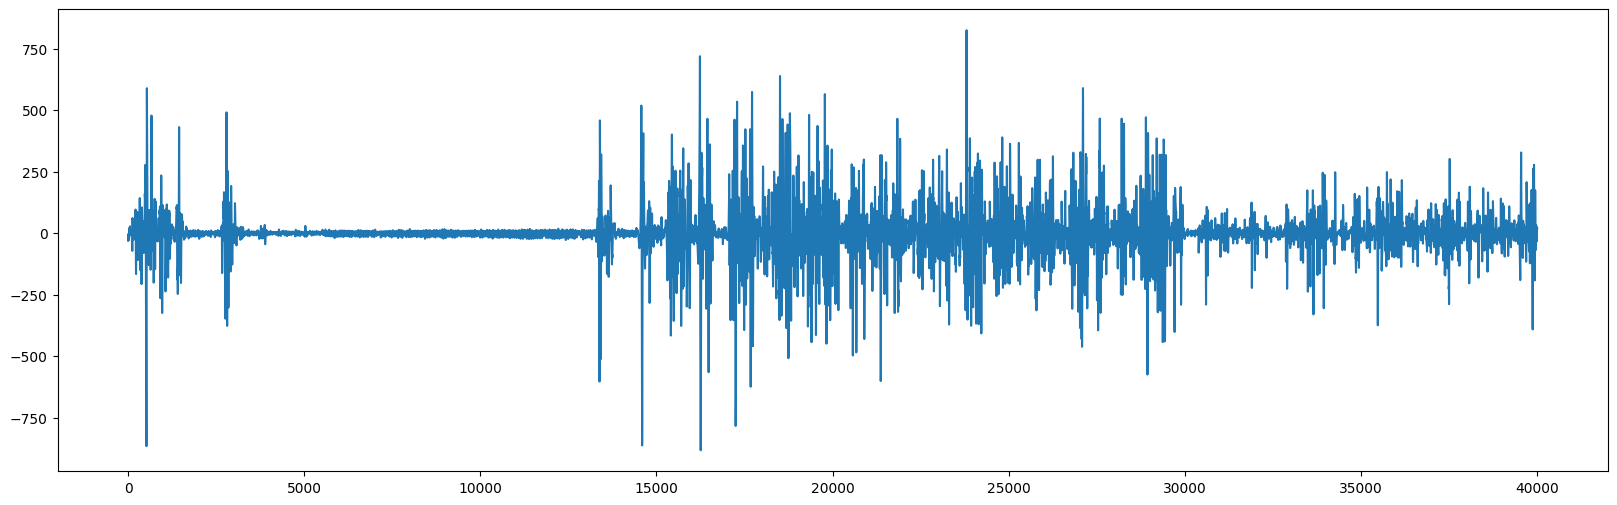

In [ ]:
# Define start and stop variables
start = 0
stop = 40000

# Change signal into vertical markers in the plot of the original signal
plt.plot(filterd2[start:stop])

plt.scatter(ppg_peaks_corrected, filterd2[start:stop][ppg_peaks_corrected], color='r')
plt.show()


# fig, ax = plt.subplots()
# sns.lineplot(data=filterd2[0:15000], ax=ax)
# for i in range(len(signal)):
#     plt.axvline(i, color='r', linestyle='--', alpha=1, linewidth=0.3)

### I COULD EXPAND IT WITH SPARSE SIGNAL RECONSTRUCTION

Originally from TROIKA paper
sparse signal reconstruction (SSR):
Sources describing it:
"[19] I. F. Gorodnitsky and B. D. Rao, “Sparse signal reconstruction from limited data using FOCUSS: a re-weighted minimum norm algorithm,” IEEE Trans. on Signal Processing, vol. 45, no. 3, pp. 600–616, 1997. [20] D. Donoho, “Compressed sensing,” IEEE Transactions on Information Theory, vol. 52, no. 4, pp. 1289–1306, 2006. [21] M. Elad, Sparse and Redundant Representations: From Theory to Applications in Signal and Image Processing. Springer, 2010."

Examples from Github:
- Done in Python: https://github.com/DingNingCN/OMP-algorithm-compressed-sensing/blob/main/3.OMP_Algorithm%20Reconstruction.ipynb
- Done in Matlab: https://github.com/sachin-chandani/Heart-Rate-Monitoring-PPG
- May also be relevant: https://github.com/leopoldjouffroy/Sparse-signal-reconstruction

In [ ]:
n = 10000
# Create full arrays of zeros with the same length as the 'ppg_clean', 'ppg_bandpassed', and 'ppg_moving_average' columns
ppg_peaks_binary_clean = np.zeros(len(ppg_df['ppg_clean']))
ppg_peaks_binary_bandpassed = np.zeros(len(ppg_df['ppg_bandpassed']))
ppg_peaks_binary_moving_average = np.zeros(len(ppg_df['ppg_moving_average']))

# Add 1's to the arrays of zeros for the indexes mentioned in the 'ppg_peaks_corrected' arrays
ppg_peaks_binary_clean[ppg_peaks_clean_corrected] = 1
ppg_peaks_binary_bandpassed[ppg_peaks_bandpassed_corrected] = 1
ppg_peaks_binary_moving_average[ppg_peaks_moving_average_corrected] = 1

# Make similar plots for 1/10th of the data
ppg_df_subset = ppg_df.iloc[0:n]
ppg_peaks_binary_clean_subset = ppg_peaks_binary_clean[0:n]
ppg_peaks_binary_bandpassed_subset = ppg_peaks_binary_bandpassed[0:n]
ppg_peaks_binary_moving_average_subset = ppg_peaks_binary_moving_average[0:n]

# Create line plots for 'ppg_clean', 'ppg_bandpassed', and 'ppg_moving_average'
fig, axs = plt.subplots(3, figsize=(15, 15))

sns.lineplot(ax=axs[0], data=ppg_df_subset, x=ppg_df_subset.index, y='ppg_clean')
sns.lineplot(ax=axs[1], data=ppg_df_subset, x=ppg_df_subset.index, y='ppg_bandpassed')
sns.lineplot(ax=axs[2], data=ppg_df_subset, x=ppg_df_subset.index, y='ppg_moving_average')

# Get the indices where ppg_peaks_binary_subset is 1
peak_indices_clean = np.where(ppg_peaks_binary_clean_subset == 1)[0]
peak_indices_bandpassed = np.where(ppg_peaks_binary_bandpassed_subset == 1)[0]
peak_indices_moving_average = np.where(ppg_peaks_binary_moving_average_subset == 1)[0]

# Add scatter plots for the peaks
axs[0].scatter(x=ppg_df_subset.index[peak_indices_clean], y=ppg_df_subset['ppg_clean'].iloc[peak_indices_clean], color='red', label='PPG Peaks Clean')
axs[1].scatter(x=ppg_df_subset.index[peak_indices_bandpassed], y=ppg_df_subset['ppg_bandpassed'].iloc[peak_indices_bandpassed], color='red', label='PPG Peaks Bandpassed')
axs[2].scatter(x=ppg_df_subset.index[peak_indices_moving_average], y=ppg_df_subset['ppg_moving_average'].iloc[peak_indices_moving_average], color='red', label='PPG Peaks Moving Average')

plt.show()

NameError: name 'ppg_peaks_clean_corrected' is not defined

---

CHECKPOINT

In [ ]:
%pip install PyWavelets
import pywt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
import pickle
import plotly.express as px
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
import neurokit2 as nk
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 6)
plt.style.use('ggplot') # nicer plots

import os, re
from importlib import reload
import empatica_helpers as eh
import helpers as h
import heartpy as hp

# eh.move_folders_to_root('input/empatica/')
# eh.rename_folders('input/empatica/')

dir_list = h.get_dir_list('input/empatica/')

df = pd.read_csv('output/empatica_raw.csv')
ibi_df = pd.read_csv('output/empatica_ibi.csv')
df.head()
len(df)

Note: you may need to restart the kernel to use updated packages.


/var/folders/4y/grqbq6j10592pmzzhgzbxdmr0000gn/T/ipykernel_49354/3058405403.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


12413182

## X-LMS Implementation in Python

### 1. Bandpass filter

In [ ]:
from scipy.signal import butter, sosfilt

fs = 64
lowcut = 0.30000001
highcut = 5

def butter_bandpass(lowcut, highcut, fs, order=4):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

# Bandpass filter
ppg_bandpassed = butter_bandpass_filter(df['bvp'], lowcut, highcut, fs)
df['ppg_bandpassed'] = ppg_bandpassed

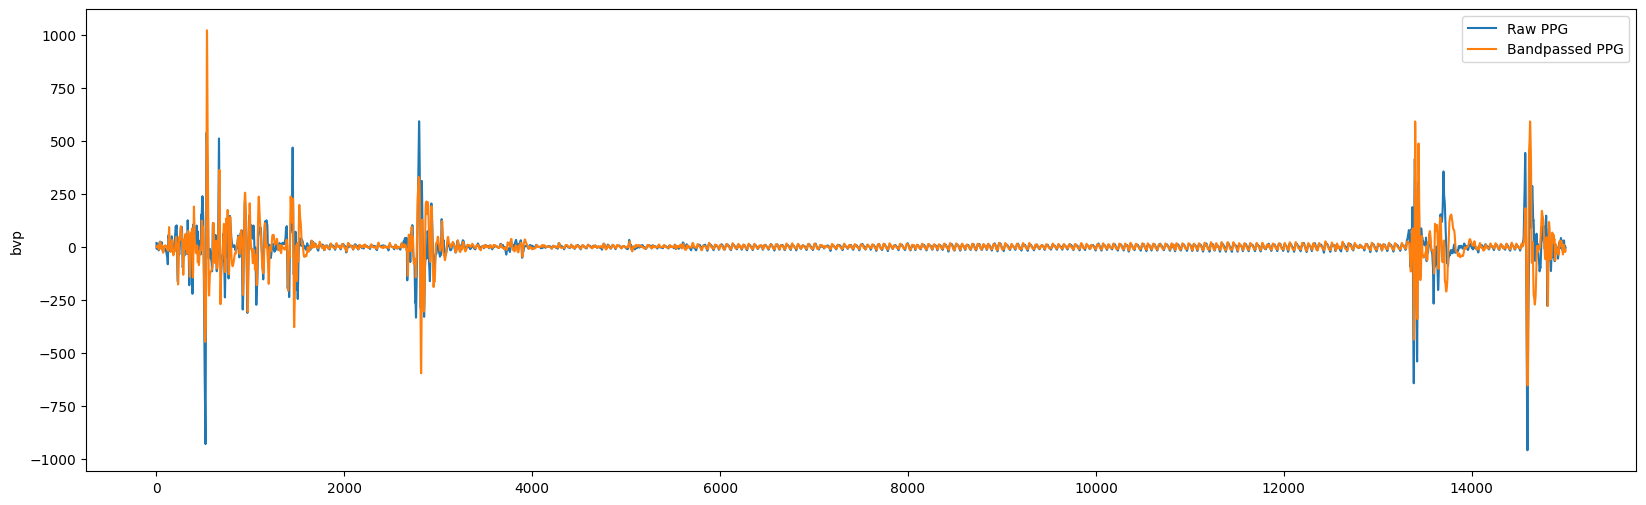

In [ ]:
sns.lineplot(data=df['bvp'][0:15000], label='Raw PPG')
sns.lineplot(data=ppg_bandpassed[0:15000], label='Bandpassed PPG')
plt.show()

### 2. Reference generation

### Singular Value Decomposition

In [ ]:
# 2D array of bandpassed_pgg, acc_x, acc_y, acc_z
a = df[['ppg_bandpassed', 'acc_x', 'acc_y', 'acc_z']].values
# print(a.shape) : (12413182, 4)

U, S, Vh = np.linalg.svd(a)

print(U.shape, S.shape, Vh.shape)

MemoryError: Unable to allocate 1.09 PiB for an array with shape (12413182, 12413182) and data type float64

### Statistical methods

In [ ]:
win = 1200  # in ms, based on HR of 50 bpm
fs = 64

results = pd.DataFrame()

# Calculate the statistics for each column
for column in ['bvp', 'acc_x', 'acc_y', 'acc_z']:
    kurt = df[column].rolling(fs * win // 1000, center=True).kurt()
    skew = df[column].rolling(fs * win // 1000, center=True).skew()
    std = df[column].rolling(fs * win // 1000, center=True).std()

    # Add the results to the DataFrame
    results[column] = df[column]
    results[column + '_kurt'] = kurt
    results[column + '_skew'] = skew
    results[column + '_std'] = std

results.head(100)

,bvp,bvp_kurt,bvp_skew,bvp_std,acc_x,acc_x_kurt,acc_x_skew,acc_x_std,acc_y,acc_y_kurt,acc_y_skew,acc_y_std,acc_z,acc_z_kurt,acc_z_skew,acc_z_std
0,17.77,NaN,NaN,NaN,15.00,NaN,NaN,NaN,-33.00,NaN,NaN,NaN,-55.00,NaN,NaN,NaN
1,-0.42,NaN,NaN,NaN,8.88,NaN,NaN,NaN,-29.52,NaN,NaN,NaN,-53.18,NaN,NaN,NaN
2,-9.45,NaN,NaN,NaN,11.00,NaN,NaN,NaN,-29.00,NaN,NaN,NaN,-51.00,NaN,NaN,NaN
3,-9.99,NaN,NaN,NaN,20.28,NaN,NaN,NaN,-33.89,NaN,NaN,NaN,-52.02,NaN,NaN,NaN
4,-6.08,NaN,NaN,NaN,26.00,NaN,NaN,NaN,-38.00,NaN,NaN,NaN,-53.00,NaN,NaN,NaN
5,-1.93,NaN,NaN,NaN,21.96,NaN,NaN,NaN,-36.44,NaN,NaN,NaN,-51.32,NaN,NaN,NaN
6,0.47,NaN,NaN,NaN,13.00,NaN,NaN,NaN,-34.00,NaN,NaN,NaN,-52.00,NaN,NaN,NaN
7,1.67,NaN,NaN,NaN,6.14,NaN,NaN,NaN,-35.96,NaN,NaN,NaN,-58.39,NaN,NaN,NaN
8,3.23,NaN,NaN,NaN,2.00,NaN,NaN,NaN,-38.00,NaN,NaN,NaN,-63.00,NaN,NaN,NaN
9,5.96,NaN,NaN,NaN,-1.27,NaN,NaN,NaN,-34.45,NaN,NaN,NaN,-58.44,NaN,NaN,NaN


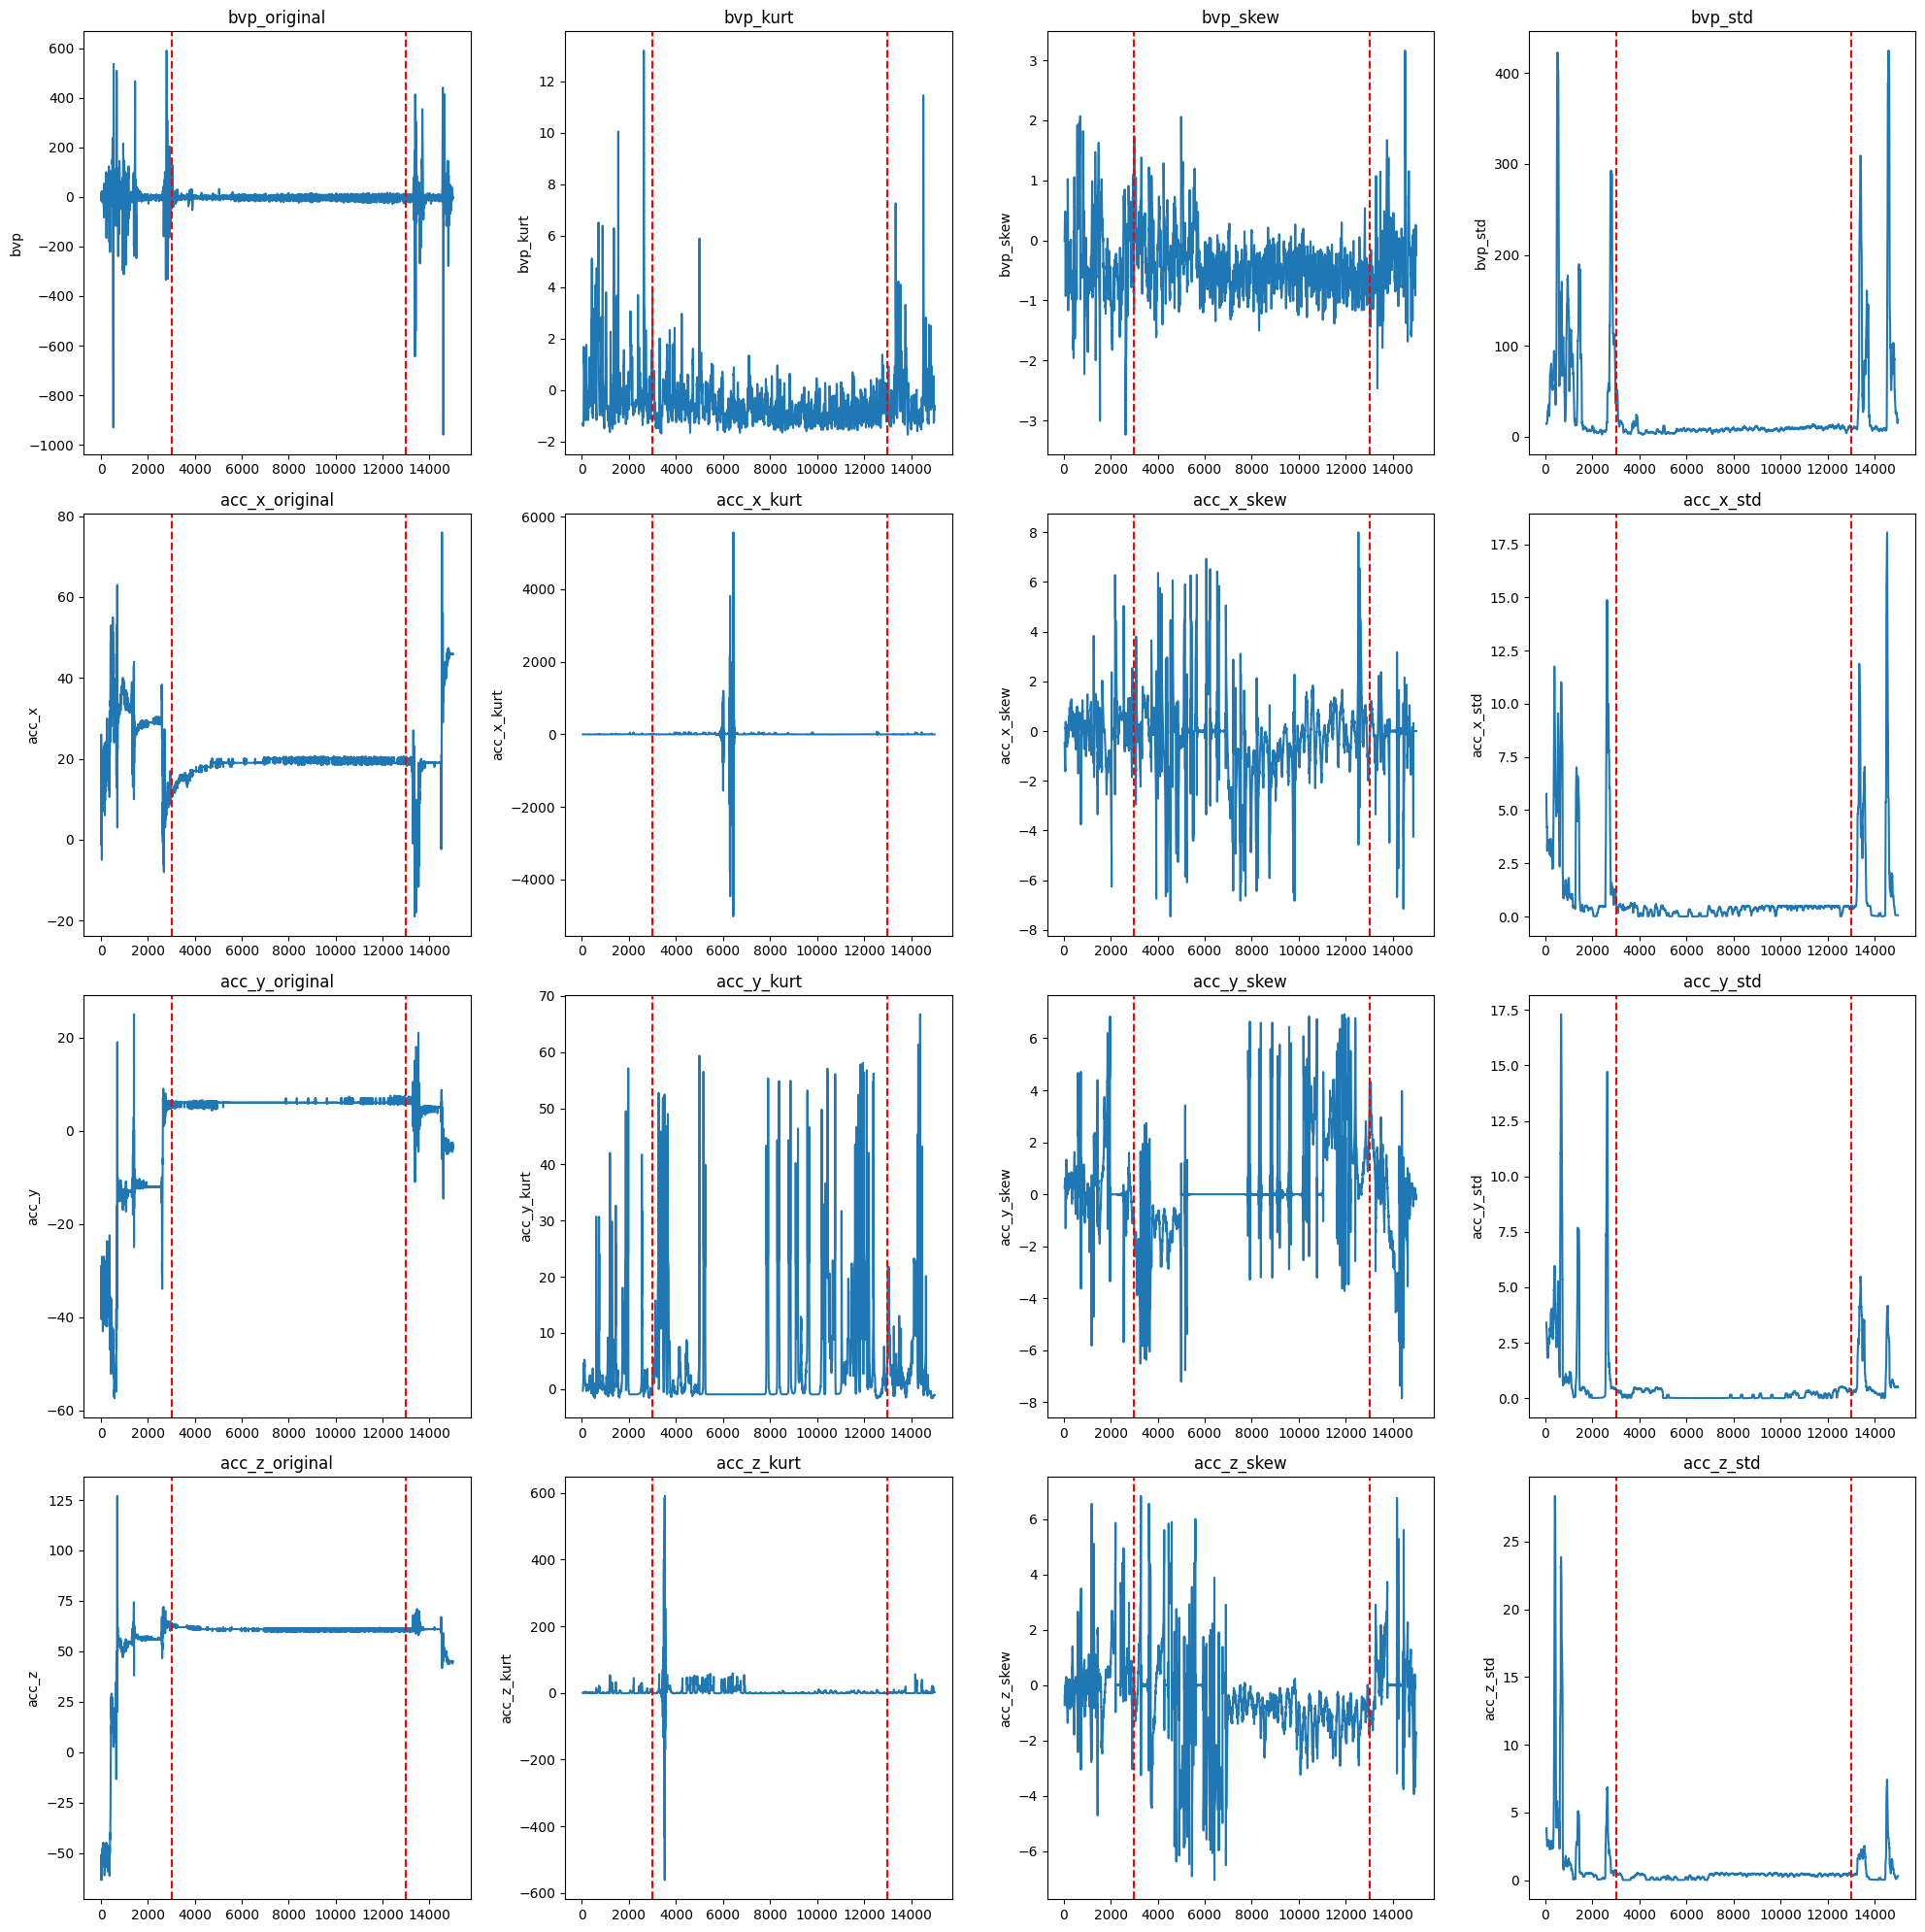

In [ ]:
# Create a grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

# Define the columns and statistics
columns = ['bvp', 'acc_x', 'acc_y', 'acc_z']
stats = ['original', 'kurt', 'skew', 'std']

# Plot each statistic for each column
for i, column in enumerate(columns):
    for j, stat in enumerate(stats):
        if stat == 'original':
            sns.lineplot(ax=axs[i, j], data=df[column].iloc[0:15000])
        else:
            sns.lineplot(ax=axs[i, j], data=results[f'{column}_{stat}'].iloc[0:15000])
        
        # Add vertical lines at index 3000 and 13000
        axs[i, j].axvline(3000, color='red', linestyle='--')
        axs[i, j].axvline(13000, color='red', linestyle='--')
        
        axs[i, j].set_title(f'{column}_{stat}')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Calculate the square root of the square of each feature
sqrt_features = np.sqrt(results**2)

# # Standardize the features
scaler = StandardScaler()
standardized_features = scaler.fit_transform(sqrt_features)

# Define the weights for the features
weights = np.ones(len(results.columns))

# Get the indices of the 'std' columns
std_indices = [i for i, col in enumerate(results.columns) if 'std' in col]

# Set the weight for the 'std' columns to 2
weights[std_indices] = 2
# print(weights)

# Apply the weights to the standardized features
weighted_features = standardized_features * weights

# Sum the weighted features to get a single score
score = pd.Series(np.sum(weighted_features, axis=1))
score_norm = (score - score.min()) / (score.max() - score.min())

# Determine a threshold for noise
threshold = 0.01 # np.percentile(score, 5)

# Classify each data point as noise or non-noise
is_noise = score_norm > threshold

NameError: name 'results' is not defined

In [ ]:
score.min()

-8.425860077290224

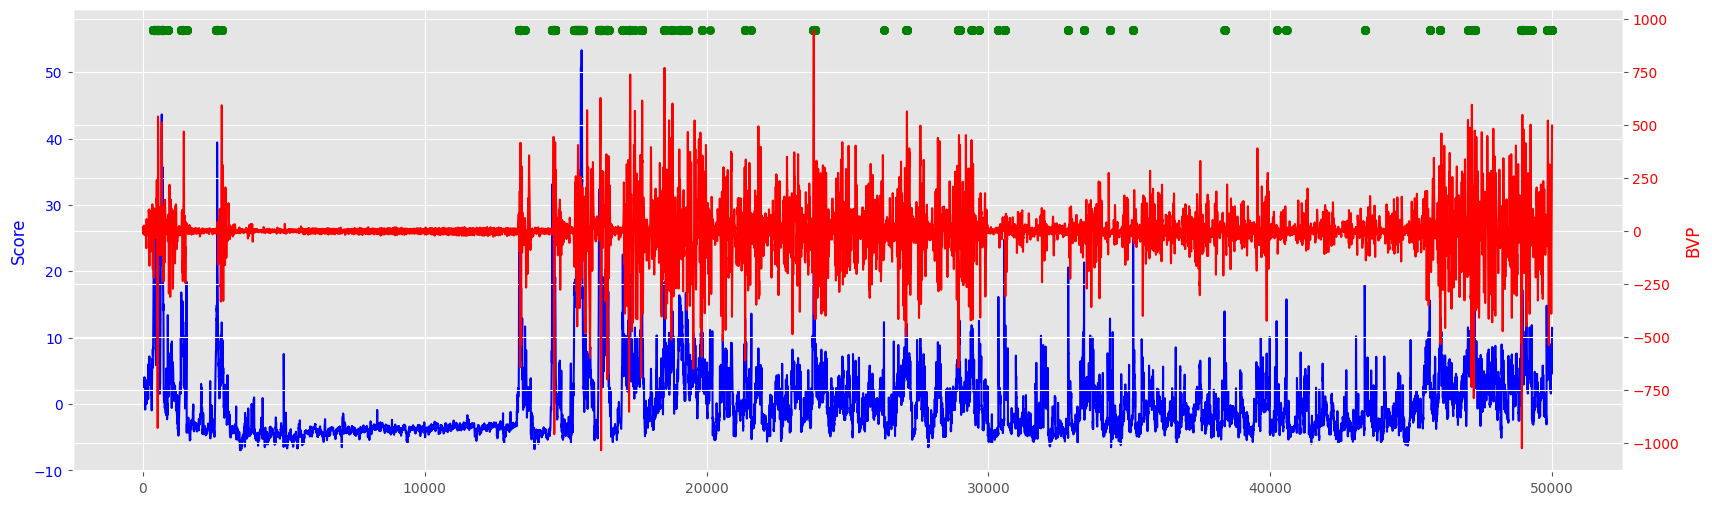

In [ ]:
fig, ax1 = plt.subplots()

start = 0
stop = 50000

# Plot the score on the first y-axis
sns.lineplot(ax=ax1, data=score[start:stop].reset_index(drop=True), color='blue')
ax1.set_ylabel('Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis that shares the x-axis
ax2 = ax1.twinx()

# Plot the bvp on the second y-axis
sns.lineplot(ax=ax2, data=df['bvp'][start:stop].reset_index(drop=True), color='red')
ax2.set_ylabel('BVP', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Get the x values where is_noise is True
is_noise_indices = np.where(is_noise[start:stop])[0]

# Get the maximum y-value of the first y-axis
ymax = ax1.get_ylim()[1]

# Add a dot for True values in is_noise at the top of the chart
ax1.scatter(is_noise_indices, [ymax]*len(is_noise_indices), color='green')

# Show the plot
plt.show()

In [ ]:
print(len(score))
print(len(df['bvp']))

12413182
12413182


In [ ]:
import padasip as pa

n = 3

d = df['bvp'].values
# d = d[n:]  # Shift 'd' by 'n' elements
x = df[['acc_x', 'acc_y', 'acc_z']].values
# x = pa.input_from_history(x, n)[:-1]  # Create 'x' and remove the last 'n' elements

# Initialize the adaptive filter
f = pa.filters.AdaptiveFilter(model="LMS", n=n, mu=0.05, w="random")

# Train the filter on the PPG signal and the noise estimate
y, e, w = f.run(d, x)

# NOTE: LMS is actually just stochastic gradient descent. 

KeyError: ('acc_x', 'acc_y', 'acc_z')

/var/folders/4y/grqbq6j10592pmzzhgzbxdmr0000gn/T/ipykernel_49354/2644830874.py:8: RuntimeWarning: overflow encountered in square
  plt.plot(10*np.log10(e**2),"r", label="e - error [dB]");plt.legend()


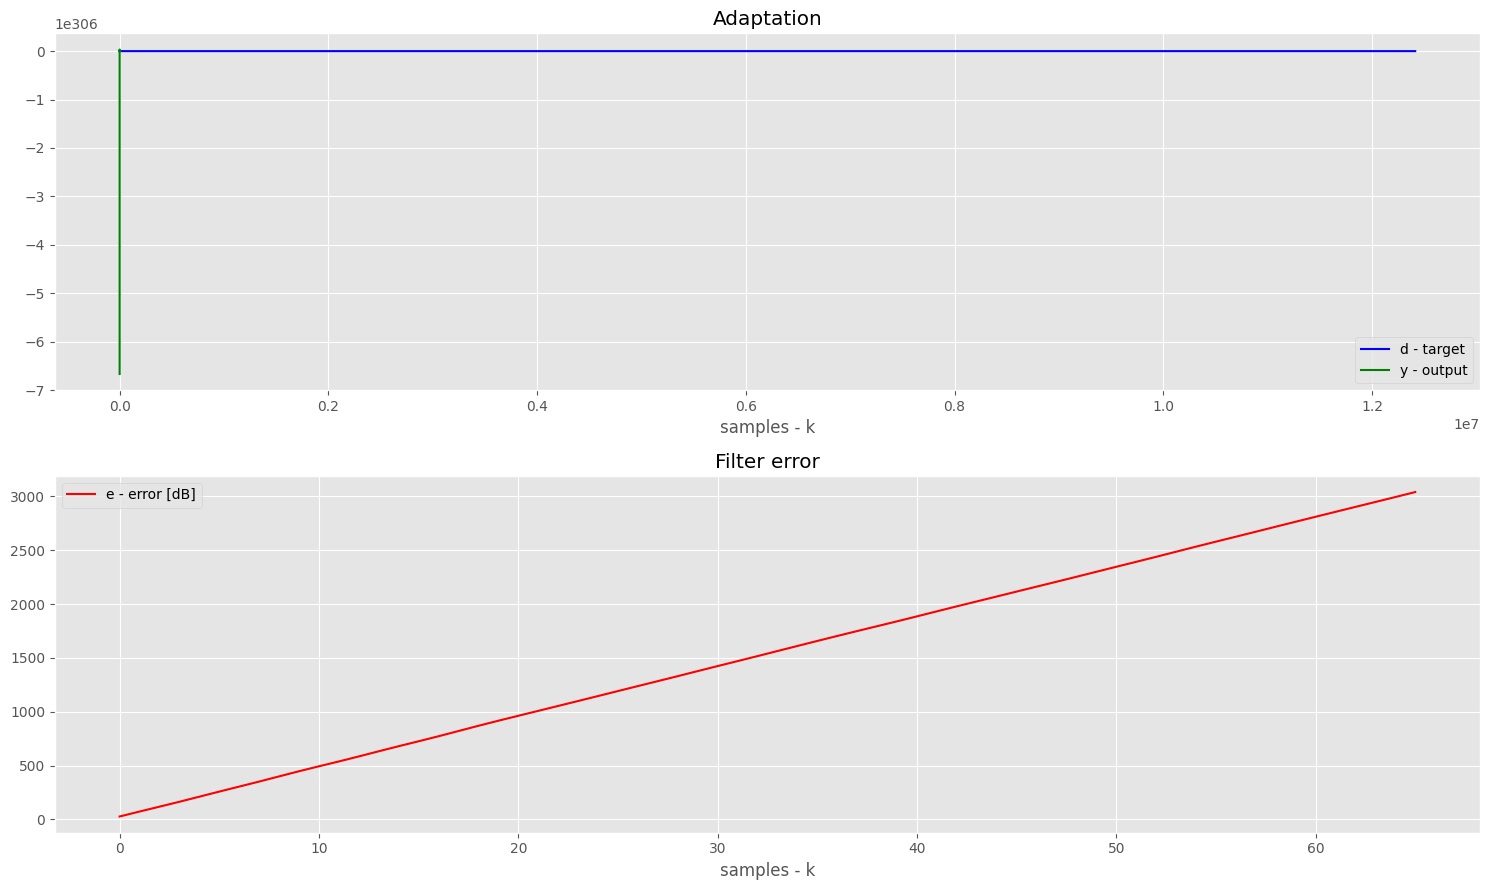

In [ ]:
plt.style.use('ggplot') # nicer plots
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(d,"b", label="d - target")
plt.plot(y,"g", label="y - output");plt.legend()
plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10(e**2),"r", label="e - error [dB]");plt.legend()
plt.tight_layout()
plt.show()

<Axes: ylabel='bvp'>

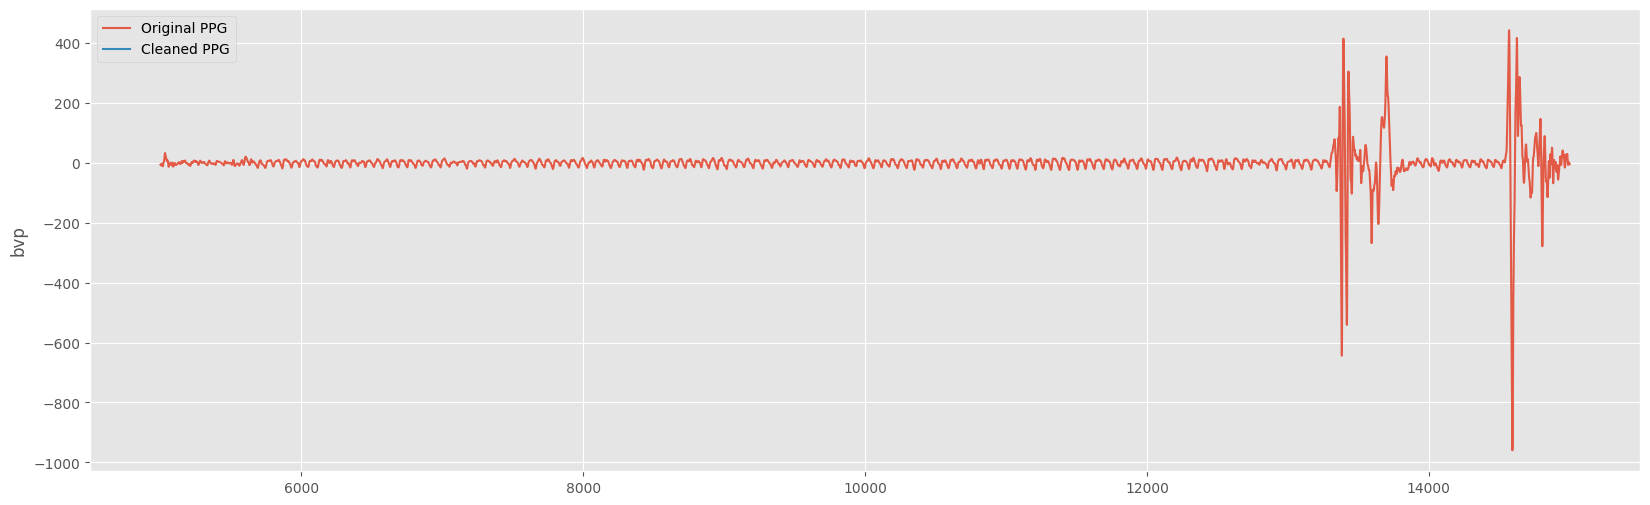

In [ ]:
ppg_clean = d - y

# Plot the original PPG signal and the cleaned PPG signal
fig, ax = plt.subplots()
sns.lineplot(data=df['bvp'][5000:15000], ax=ax, label='Original PPG', alpha = 0.9)
sns.lineplot(data=ppg_clean[5000:15000], ax=ax, label='Cleaned PPG')

In [ ]:
errors_e, mu_range = f.explore_learning(d, x,
                mu_start=0.01,
                mu_end=1.,
                steps=100, ntrain=0.5, epochs=1,
                criteria="MSE")

plt.plot(mu_range, 10*np.log10(errors_e))

AttributeError: 'FilterLMS' object has no attribute 'explore_learning'